In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

import importlib
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import TurbidostatClass
import tools

importlib.reload(TurbidostatClass)

<module 'TurbidostatClass' from 'c:\\Users\\Orlando\\Desktop\\DREAM_repo\\TurbidostatClass.py'>

In [2]:
turbido = TurbidostatClass.Turbidostat('20230717_chlamy_WT_steady')

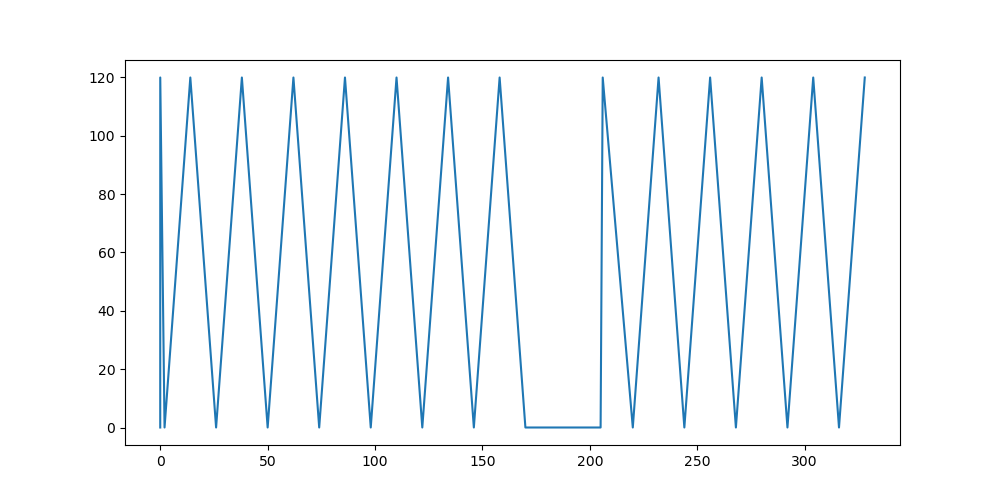

In [11]:
fig, ax = plt.subplots(1,1, figsize=(10,5)) 
ax.plot(turbido.data['ch1']['light']['time']/(60*60), turbido.data['ch1']['light']['val'])

KeyError: 'light'

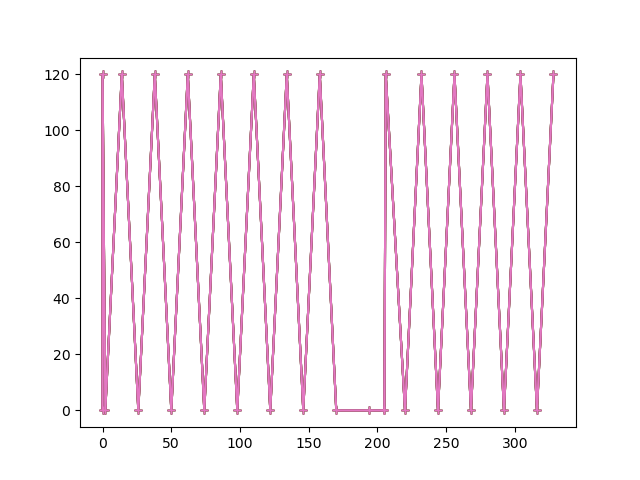

In [7]:
fig, ax = plt.subplots()
for channel in range(8):
    ax.plot(turbido.data[f'ch{channel+1}']['consumption'].time/(60*60), turbido.data[f'ch{channel+1}']['consumption'].val, '+-', label = f'ch{channel+1}')
ax.legend()

In [4]:
channel

7

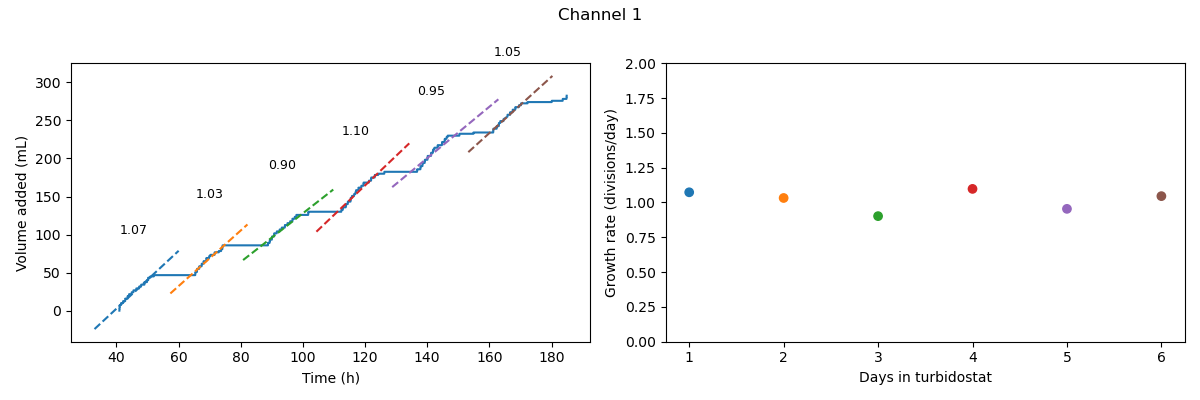

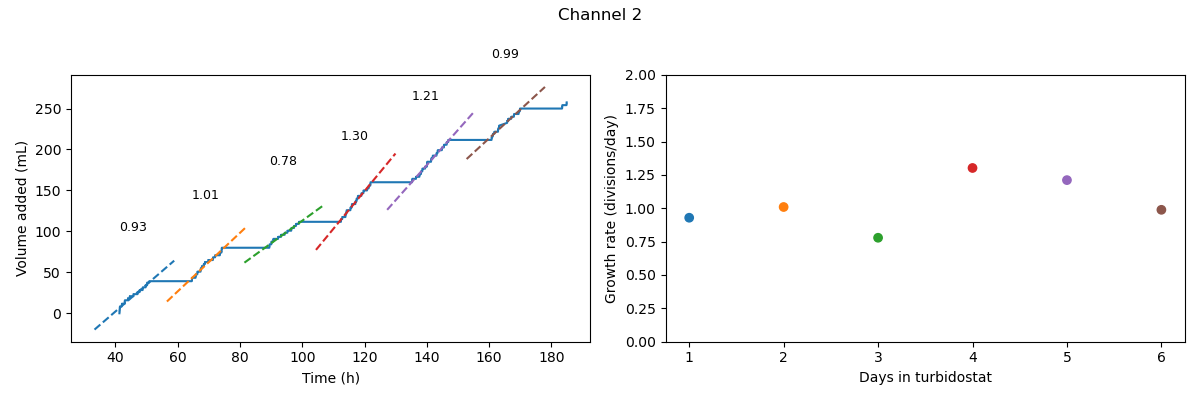

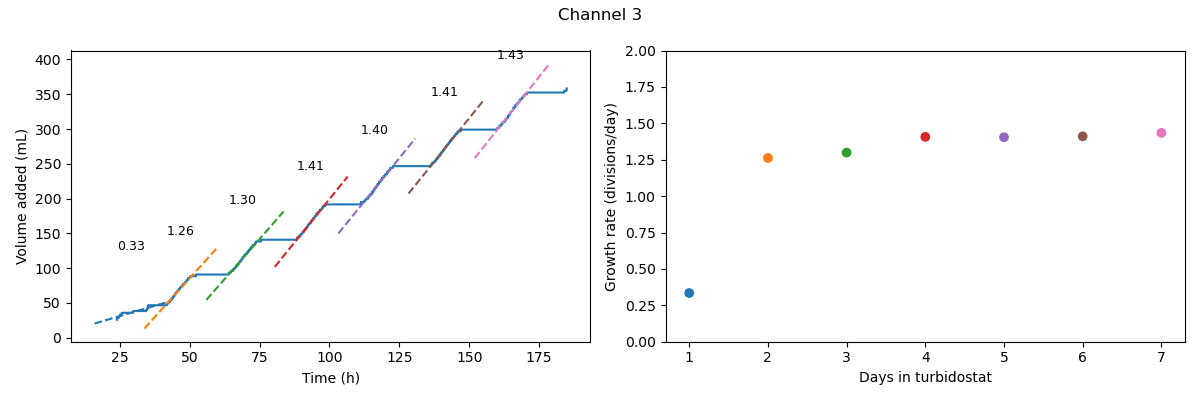

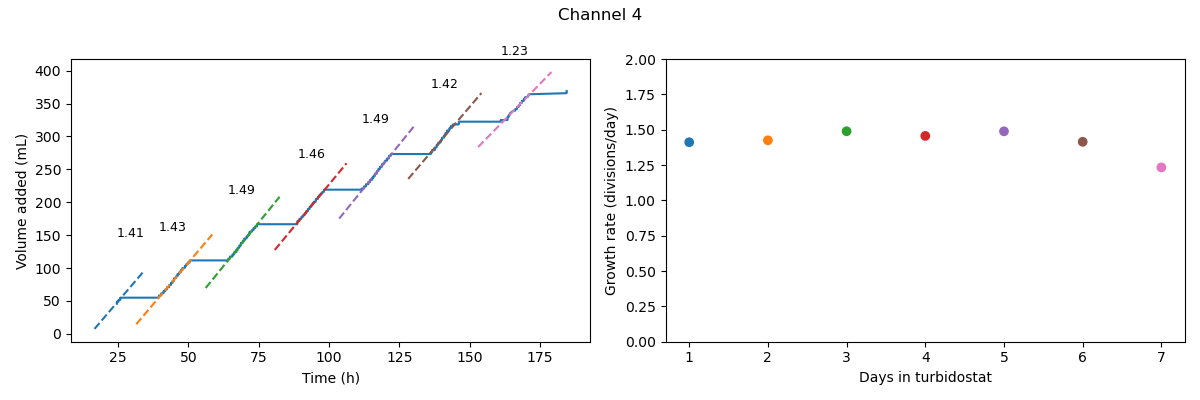

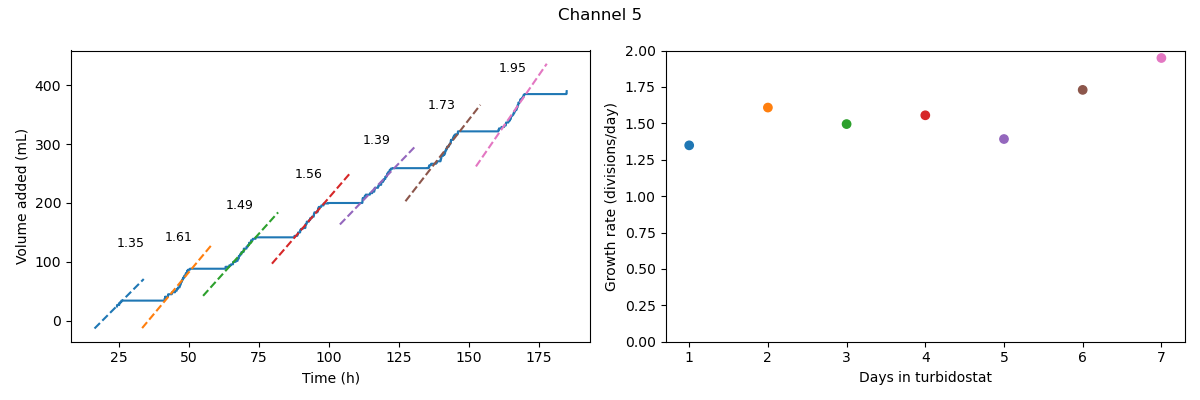

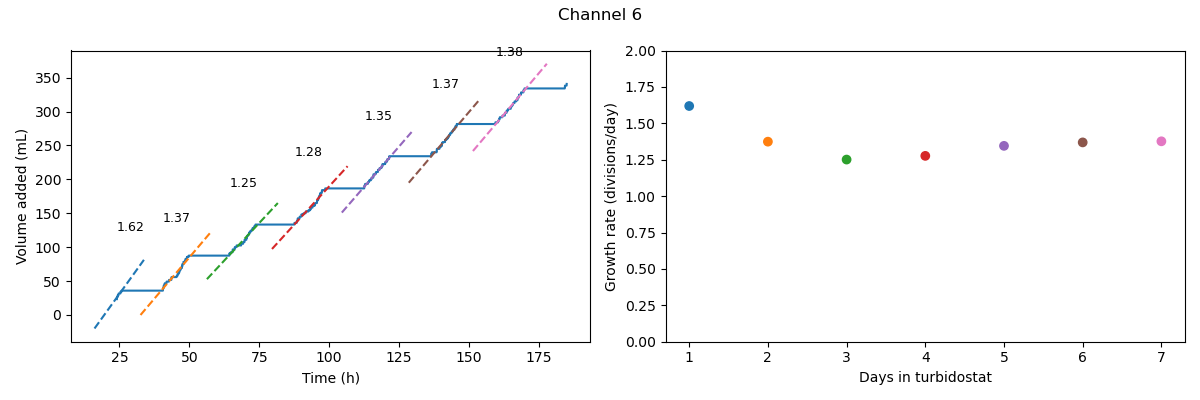

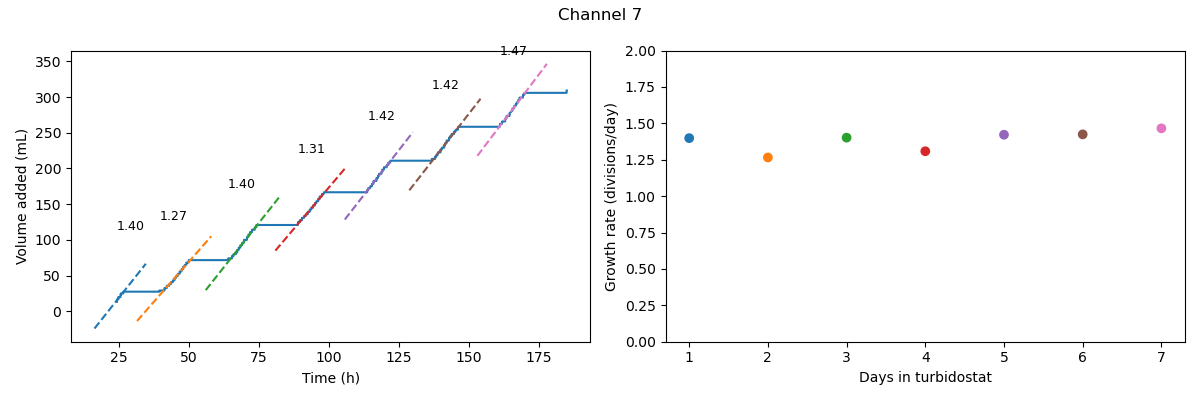

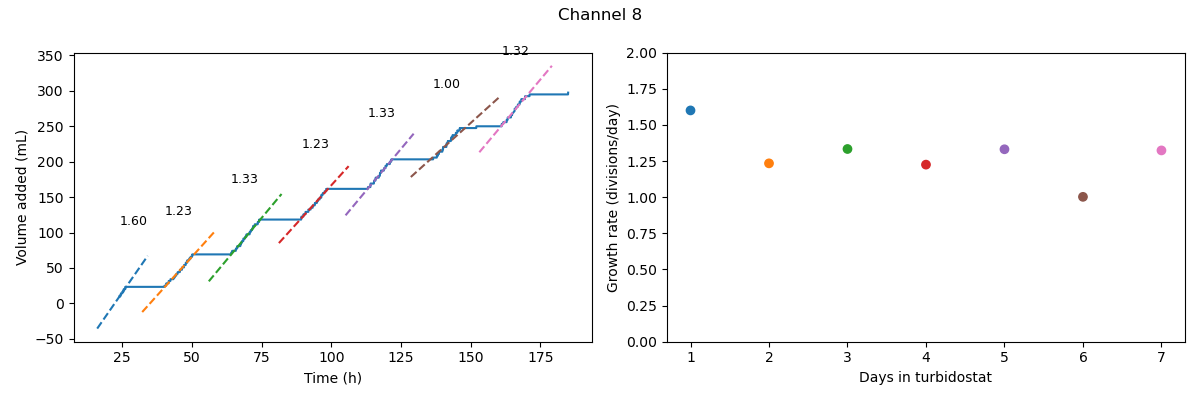

In [16]:
def get_growth_rate(x, y, channel):
    x= np.array(x)
    y = np.array(y)
    times = []
    growth_period = []
    start = None
    for i in range(len(y)):
        if i == 0:
            pass
        elif start is None:
            start = i
        elif x[i]-x[i-1] > 6:
            if y[i] - y[start] > 5:
                times.append(x[start:i])
                growth_period.append(y[start:i])
            start = None
        else:
            continue

    fig, ax = plt.subplots(1,2, figsize = (12,4))
    title = fig.suptitle(f'Channel {channel}')
    ax[0].plot(x, y)

    growth_rate = []
    colors = []

    for i in range(len(times)):
        popt = []
        xfit = []
        yfit = []
        colors.append(f'C{i}')
        popt, xfit, yfit = tools.lin_fit(times[i], growth_period[i], times[i][0]-8, times[i][-1]+8, 100)
        growth_rate.append(popt[0]*12/42.5)
        ax[0].plot(xfit, yfit, '--', color = colors[i])
        ax[0].text(times[i][0], growth_period[i][0]+100, f'{growth_rate[i]:.2f}', fontsize=9)
    ax[0].set_xlabel('Time (h)')
    ax[0].set_ylabel('Volume added (mL)')
        
    ax[1].scatter(np.arange(0,len(growth_rate))+1, growth_rate, c = colors)
    ax[1].set_ylim(0,2)
    ax[1].set_xlabel('Days in turbidostat')
    ax[1].set_ylabel('Growth rate (divisions/day)')
    
    fig.tight_layout()
    fig.savefig(f'{turbido.fig_folder}/Channel_{channel}_growth_rate.png', dpi = 300)
    
    return growth_rate

growth_rates = []
t_start = 24 # hours
t_end = 185 # hours
for i in range(8):
    x = turbido.data[f'ch{i+1}']['consumption']['time']/(60*60)
    index_start = np.where(x > t_start)[0][0]
    index_end = np.where(x > t_end)[0][0]
    x = x[index_start:index_end]
    y = turbido.data[f'ch{i+1}']['consumption']['val'][index_start:index_end]
    growth_rates.append(get_growth_rate(x, y, i+1))
    



    


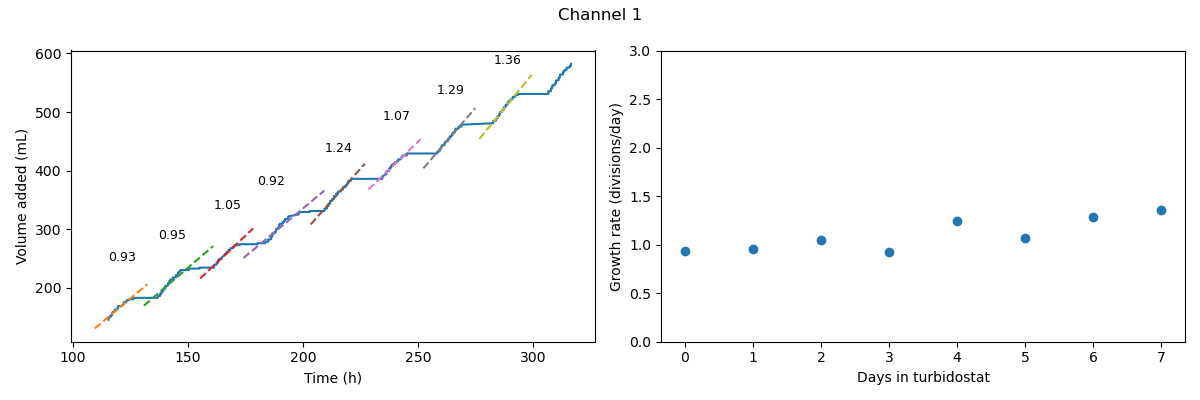

In [317]:
i = 0
channel = i+1

x = turbido.data[f'ch{i+1}']['consumption']['time'][350:]/(60*60)
y = turbido.data[f'ch{i+1}']['consumption']['val'][350:]

x= np.array(x)
y = np.array(y)
times = []
growth_period = []
start = None
for i in range(len(y)):
    if i == 0:
        pass
    elif start is None:
        start = i
    elif x[i]-x[i-1] > 6:
        times.append(x[start:i])
        growth_period.append(y[start:i])
        start = None
    else:
        continue

fig, ax = plt.subplots(1,2, figsize = (12,4))
title = fig.suptitle(f'Channel {channel}')
ax[0].plot(x, y)

growth_rate = []

for i in range(len(times)):
    popt = []
    xfit = []
    yfit = []
    popt, xfit, yfit = tools.lin_fit(times[i], growth_period[i], times[i][0]-6, times[i][-1]+6, 100)
    growth_rate.append(popt[0]*24/85)
    ax[0].plot(xfit, yfit, '--')
    ax[0].text(times[i][0], growth_period[i][0]+100, f'{growth_rate[i]:.2f}', fontsize=9)
ax[0].set_xlabel('Time (h)')
ax[0].set_ylabel('Volume added (mL)')
    
ax[1].plot(growth_rate, 'o')
ax[1].set_ylim(0,3)
ax[1].set_xlabel('Days in turbidostat')
ax[1].set_ylabel('Growth rate (divisions/day)')

fig.tight_layout()
fig.savefig(f'{turbido.fig_folder}/Channel_{channel}_growth_rate.png', dpi = 300)

In [314]:
times[1]

array([404887], dtype=int64)

[0.22436961866626298,
 1.2989031865878744,
 1.4071018461548233,
 1.4039668811169281,
 1.4106791284417686,
 1.4339412847164577,
 1.4753479122912807,
 1.511450254607788,
 1.4191394366212993,
 1.5103585387324374,
 1.4631717148637777]

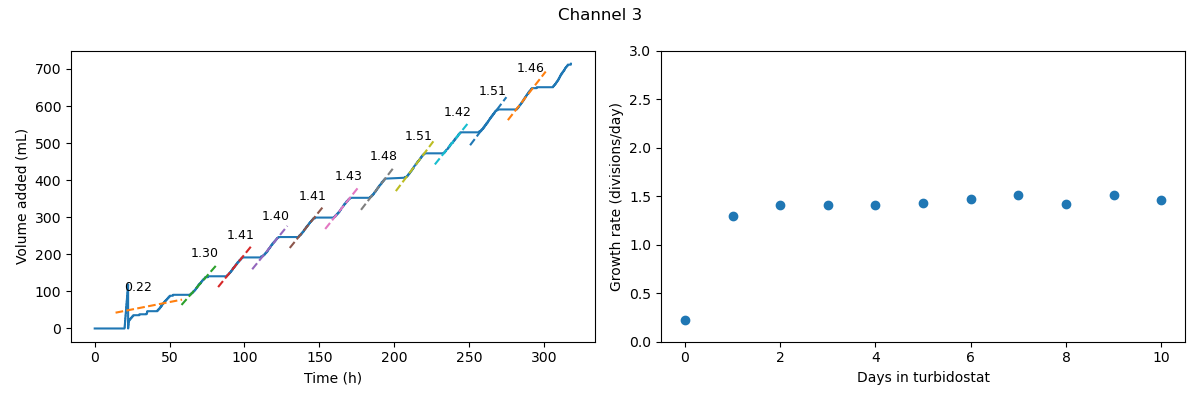

In [301]:
i = 2
get_growth_rate(turbido.data[f'ch{i+1}']['consumption'].time/(60*60), turbido.data[f'ch{i+1}']['consumption'].val, i+1)

In [308]:
import numpy as np

x = turbido.data[f'ch{i+1}']['consumption']['time']/(60*60
                                                     )
index = np.where(x > 24)[0][0]
print(f"The index where x > 24 is {index}")

The index where x > 24 is 350


In [241]:
index

0

In [163]:
def find_plateaus(F, min_length=200, tolerance = 0.75, smoothing=25):
    '''
    Finds plateaus of signal using second derivative of F.

    Parameters
    ----------
    F : Signal.
    min_length: Minimum length of plateau.
    tolerance: Number between 0 and 1 indicating how tolerant
        the requirement of constant slope of the plateau is.
    smoothing: Size of uniform filter 1D applied to F and its derivatives.
    
    Returns
    -------
    plateaus: array of plateau left and right edges pairs
    dF: (smoothed) derivative of F
    d2F: (smoothed) Second Derivative of F
    '''
    import numpy as np
    from scipy.ndimage.filters import uniform_filter1d
    
    # calculate smooth gradients
    smoothF = uniform_filter1d(F, size = smoothing)
    dF = uniform_filter1d(np.gradient(smoothF),size = smoothing)
    d2F = uniform_filter1d(np.gradient(dF),size = smoothing)
    
    def zero_runs(x):
        '''
        Helper function for finding sequences of 0s in a signal
        https://stackoverflow.com/questions/24885092/finding-the-consecutive-zeros-in-a-numpy-array/24892274#24892274
        '''
        iszero = np.concatenate(([0], np.equal(x, 0).view(np.int8), [0]))
        absdiff = np.abs(np.diff(iszero))
        ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
        return ranges
    
    # Find ranges where second derivative is zero
    # Values under eps are assumed to be zero.
    eps = np.quantile(abs(d2F),tolerance) 
    smalld2F = (abs(d2F) <= eps)
    
    # Find repititions in the mask "smalld2F" (i.e. ranges where d2F is constantly zero)
    p = zero_runs(np.diff(smalld2F))
    
    # np.diff(p) gives the length of each range found.
    # only accept plateaus of min_length
    plateaus = p[(np.diff(p) > min_length).flatten()]
    
    return (plateaus, dF, d2F)

[(0, 3), (906, 908)]

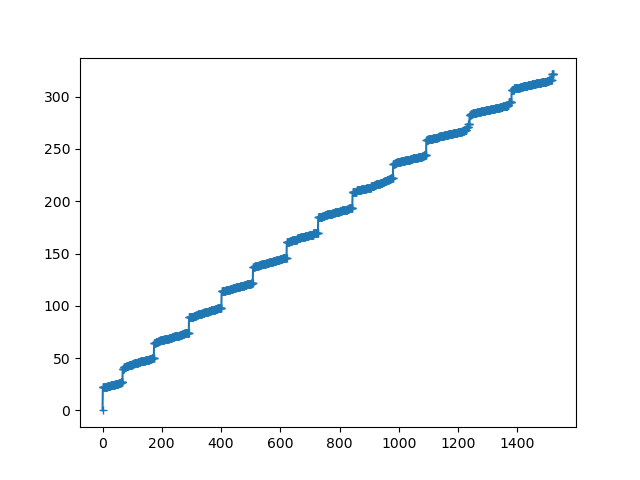

In [219]:
fig, ax = plt.subplots()
ax.plot(x, '+-')
